In [1]:
import numpy as np
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [7]:
! unzip /content/simplified-nq-train.jsonl.zip
# ! pip install kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle competitions download -c tensorflow2-question-answering

Archive:  /content/simplified-nq-train.jsonl.zip
  inflating: simplified-nq-train.jsonl  


In [8]:
import json
from tqdm.notebook import tqdm

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, SpatialDropout1D, Dense, Dropout, Input, concatenate, Conv1D, Activation, Flatten

from nltk.corpus import stopwords
import re



In [10]:
# data load preprocessing

def get_line_of_data(file):
    line = file.readline()
    line = json.loads(line)
    
    return line


def get_question_and_document(line):
    question = line['question_text']
    text = line['document_text'].split(' ')
    annotations = line['annotations'][0]
    
    return question, text, annotations
                
                
def get_long_candidate(i, annotations, candidate):
    # check if this candidate is the correct answer
    if i == annotations['long_answer']['candidate_index']:
        label = True
    else:
        label = False

    # get place where long answer starts and ends in the document text
    long_start = candidate['start_token']
    long_end = candidate['end_token']
    
    return label, long_start, long_end


def form_data_row(question, label, text, long_start, long_end):
    row = {
        'question': question,
        'long_answer': ' '.join(text[long_start:long_end]),
        'is_long_answer': label,
    }
    
    return row


# Lloading function for train and validation set
def load_data(file_path, questions_start, questions_end, validation_set= False):
    rows = []
    
    with open(file_path) as file:

        for i in tqdm(range(questions_start, questions_end)):
            line = get_line_of_data(file)
            question, text, annotations = get_question_and_document(line)

            for i, candidate in enumerate(line['long_answer_candidates']):
                label, long_start, long_end = get_long_candidate(i, annotations, candidate)
                
                if validation_set == False:
                    
                    if label == True or (i % SAMPLE_RATE == 0):
                        rows.append(
                            form_data_row(question, label, text, long_start, long_end)
                        )
                else:
                    
                    rows.append(
                            form_data_row(question, label, text, long_start, long_end)
                        )
            #print(i, len(rows))
        
    return pd.DataFrame(rows)

In [11]:
SAMPLE_RATE = 15
TRAIN_PATH = '../content/simplified-nq-train.jsonl'



In [12]:
# change the number of rows here
train_df = load_data(TRAIN_PATH, 0, 20000, validation_set= False)
val_df = load_data(TRAIN_PATH, 20000, 25000, validation_set= False)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [13]:
# import BERT tokenization

!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [14]:
! pip install sentencepiece

     |████████████████████████████████| 1.2 MB 10.2 MB/s 


In [15]:
import tensorflow_hub as hub
from sklearn import preprocessing
import tokenization


In [16]:
m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(m_url, trainable=True)

In [17]:

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=300):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [18]:
max_len = 300
train_long_answers = bert_encode(train_df['long_answer'].values, tokenizer, max_len=max_len)

train_questions = bert_encode(train_df['question'].values, tokenizer, max_len=max_len)

val_questions = bert_encode(val_df['question'].values, tokenizer, max_len=max_len)

val_long_answers = bert_encode(val_df['long_answer'].values, tokenizer, max_len=max_len)


In [19]:
input_word_ids_ans,input_mask_ans, segment_ids_ans = bert_encode(train_df['long_answer'].values, tokenizer, max_len=max_len)
input_word_ids_q,input_mask_q, segment_ids_q = bert_encode(train_df['question'].values, tokenizer, max_len=max_len)

In [20]:
input_word_ids_ans_val,input_mask_ans_val, segment_ids_ans_val = bert_encode(val_df['long_answer'].values, tokenizer, max_len=max_len)
input_word_ids_q_val,input_mask_q_val, segment_ids_q_val = bert_encode(val_df['question'].values, tokenizer, max_len=max_len)

In [21]:
# labels

train_labels = train_df.is_long_answer.astype(int).values
val_labels = val_df.is_long_answer.astype(int).values

In [ ]:
input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

clf_output = sequence_output[:, 0, :]


input_word_ids1 = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids1")
input_mask1 = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask1")
segment_ids1 = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids1")
pooled_output1, sequence_output1 = bert_layer([input_word_ids1, input_mask1, segment_ids1])

clf_output1 = sequence_output1[:, 0, :]


combined_x = concatenate([clf_output, clf_output1])
combined_x = Dropout(0.1)(combined_x)
combined_x = Dense(100, activation='relu')(combined_x)
combined_x = Dropout(0.1)(combined_x)
output = Dense(1, activation='sigmoid')(combined_x)

#distance=tf.expand_dims(tf.reduce_sum(tf.multiply(clf_output, clf_output1),axis=1),axis=-1)
#output = Dense(1, activation='sigmoid')(distance)

model = tf.keras.models.Model(inputs=[input_word_ids,input_mask,segment_ids, input_word_ids1,input_mask1,segment_ids1], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Accuracy', 'Recall', 'Precision'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 300)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 300)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 300)]        0           []                               
                                                                                                  
 input_word_ids1 (InputLayer)   [(None, 300)]        0           []                               
                                                                                              

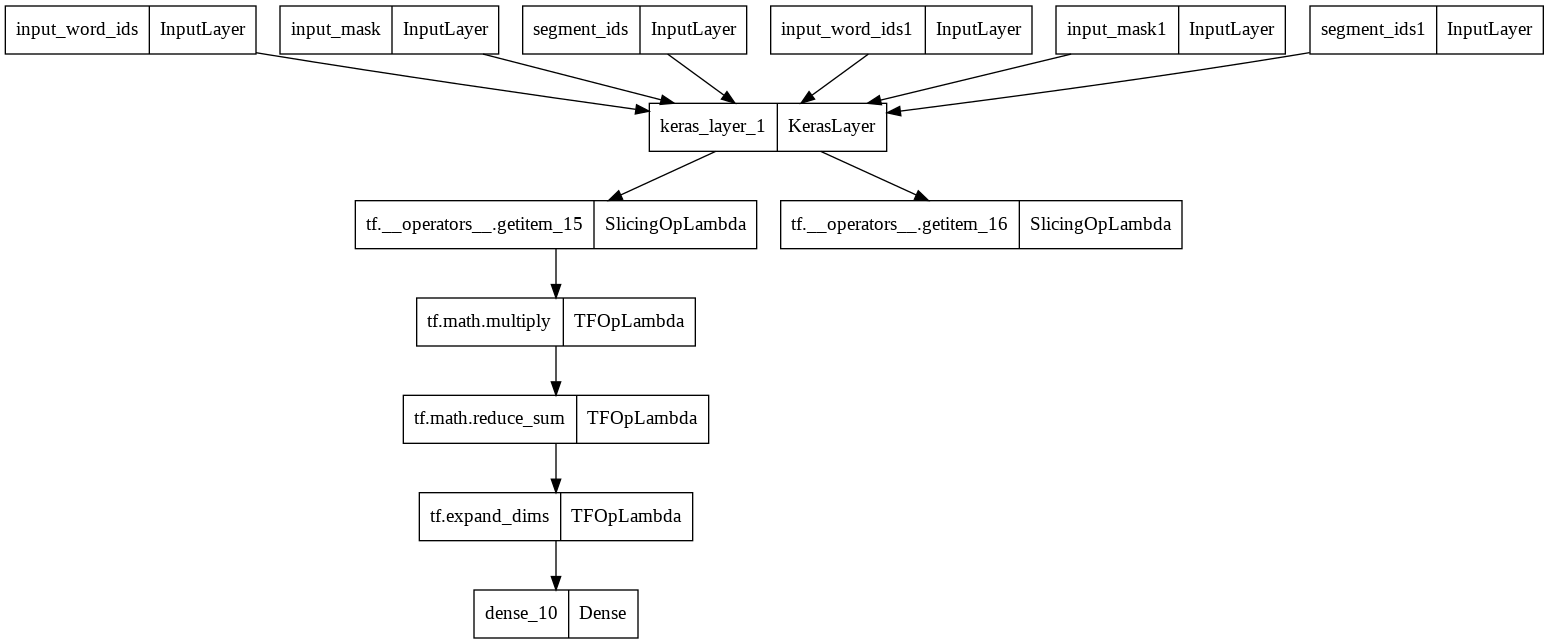

In [ ]:
tf.keras.utils.plot_model(model)

In [23]:
train_sh = model.fit(
    [input_word_ids_q,input_mask_q, segment_ids_q,input_word_ids_ans,input_mask_ans, segment_ids_ans], train_labels,
    validation_data = ([input_word_ids_q_val,input_mask_q_val, segment_ids_q_val,input_word_ids_ans_val,input_mask_ans_val, segment_ids_ans_val], val_labels),
    epochs=2,
    batch_size=6,
    verbose=1
)


Epoch 1/2
16171/16171 [==============================] - 8495s 524ms/step - loss: 0.2120 - Accuracy: 0.9482 - recall: 4.0000e-04 - precision: 0.0800 - val_loss: 0.2129 - val_Accuracy: 0.9480 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/2
16171/16171 [==============================] - 8468s 524ms/step - loss: 0.2075 - Accuracy: 0.9485 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.2189 - val_Accuracy: 0.9480 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00


In [ ]:
# evaluate the keras model
_, accuracy = model.evaluate([input_word_ids_q_val,input_mask_q_val, segment_ids_q_val,input_word_ids_ans_val,input_mask_ans_val, segment_ids_ans_val], val_labels )
print('Accuracy: %.2f' % (accuracy*100))

87/87 [==============================] - 70s 792ms/step - loss: 0.2272 - accuracy: 0.9399
Accuracy: 93.99


In [24]:
pred_train = model.predict([input_word_ids_q_val,input_mask_q_val, segment_ids_q_val,input_word_ids_ans_val,input_mask_ans_val, segment_ids_ans_val])

In [30]:
predict = [1 if i > 0.5 else 0 for i in pred_train ]

In [28]:
from sklearn.metrics import f1_score, precision_score, recall_score
import seaborn as sns

In [2]:
print("F1 score", f1_score(predict,val_labels , average='binary'))
print("precsion",precision_score(predict, val_labels, average='binary') )
print("recall", recall_score(predict, val_labels, average='binary'))




F1 score 0.39
precsion 0.32
recall 0.505
